In [1]:
import sys
import pickle
import collections
import pandas as pd
import numpy as np
from textwrap import dedent
import matplotlib.pyplot as plt
import seaborn as sns

from tf.fabric import Fabric
from tf.app import use

PAIRS = "/Users/cody/github/BH_time_collocations/cx_pilot/pairs.pkl"
TOOLS_LIB = "/Users/cody/github/BH_time_collocations/workflow/notebooks/analysis"

sys.path.append(TOOLS_LIB)

from scripts.stats.significance import apply_deltaP
from scripts.plotting import heatmap

In [2]:
with open(PAIRS, 'rb') as infile:
    loaded_pair_data = pickle.load(infile)

In [3]:
bhsa = use('etcbc/bhsa', version='c')
F, E, T, L = (getattr(bhsa.api, method) for method in "FETL")

# Looking for statistical associations with (B+(H+NOUN+H+APPO))

In [4]:
# inspect all examples first and hand-pick those to be used for the analysis

raw_samples = []


to_check = (
    loaded_pair_data["(B+(H+NOUN+H+ADJUNCT))"]["TA"] 
    + loaded_pair_data["(B+(H+NOUN+H+ADJUNCT))"]["NTA"]
)
for sample in to_check:
    pass

In [6]:
_ = bhsa.search("""

sentence
    clause typ=XQtl
    < clause typ=xYqX

""")

  0.11s 1 result


In [8]:
# bhsa.show(
#     loaded_pair_data["(B+(H+NOUN+H+ADJUNCT))"]["TA"],
#     end=25,
#     condenseType='verse',
#     extraFeatures='typ function',
# )

In [9]:
class MatchItems:
    
    def __init__(self, targetset):
        """Initialize a MatchItems object."""
        self.targetset = targetset 
        self.tagged_matches = None
    
    def _remove_prev_matches(self, target_i, matches):
        """Remove prev matches from an existing matchset."""
        matched = self.matched
        return [
            match for match in matches
            if match[target_i] not in matched
        ]
    
    def match(self, match_patterns, exclude_prev=True):
        """Map TF search templates to specific tags."""
        self.tagged_matches = collections.defaultdict(list)
        for tag, patterns in match_patterns:
            for target_i, pattern in patterns:
                results = bhsa.search(dedent(pattern), sets={"target": self.targetset}, silent=True)
                if exclude_prev:
                    results = self._remove_prev_matches(target_i, results)
                print(f'{tag}:', len(results), 'results')
                self.tagged_matches[tag].append((target_i, results))

    @property
    def matched(self):
        """Retrieve list of matched target items."""
        return [
            result[target_i] for tag in self.tagged_matches
            for target_i, matchset in self.tagged_matches[tag]
            for result in matchset
        ]

    @property
    def covered(self):
        """Retrieve the proportion of targetset that is covered by matches."""
        matchset = set(self.matched)
        target_match_intersection = matchset & self.targetset
        return len(matchset) / len(self.targetset)
    
    def breakdown_by_tag(self):
        """Show a frequency breakdown by tag."""
        pass
    
    def show_tag(self, tag):
        """Show examples for a given tag."""
        matches = [
            match for target_i, matches in self.tagged_matches[tag]
            for match in matches
        ]
        bhsa.show(
            matches,
            condenseType='clause',
            extraFeatures='function typ',
        )
        
    def show_uncovered(self):
        """Show those targets not yet retrieved."""
        covered = set(self.matched)
        uncovered_targets = [
            (targ,) for targ in self.targetset if targ not in covered
        ]
        bhsa.show(
            uncovered_targets,
            condenseType='clause',
            extraFeatures='function typ',
        )

In [10]:
ta_matchset = set(
    result[0]
    for result in loaded_pair_data["(B+(H+NOUN+H+ADJUNCT))"]["TA"]
)

In [11]:
matchpatterns = [
    
    ('WJHJ_FRONT', [
        (
            3,
            """
            clause
                =: word lex=W
                <: word lex=HJH[ vt=wayq
                <: target
            """
        ),
    ]),
    
    ('WHJH_FRONT', [
        (
            3,
            """
            c:clause
                =: word lex=W
                <: word lex=HJH[ vt=perf
                <: t:target
            
            c := t
            """
        )
    ]),
    
    ('X_FRONTED', [
        (
            1,
            """
            clause
                target
                < word pdp=verb
            """
        )
    ]),
    
    ('MEDIAL', [
        (
            2,
            """
            clause
                word pdp=verb
                < target
                < phrase function=PreC|Cmpl|Objc
            
            """
        )
    ]),   
    
    ('ADJU', [
       (
           2,
           """
           clause
               word pdp=verb
               < t1:target
           """
       )
    ]),
    
    ('NMCL_?', [
        (
            1,
            """
            clause typ=NmCl|Ellp
                target
            """
        ),
    ]),
]

#### Match TA

In [12]:
ta_matches = MatchItems(ta_matchset)
ta_matches.match(matchpatterns)

WJHJ_FRONT: 42 results
WHJH_FRONT: 28 results
X_FRONTED: 165 results
MEDIAL: 54 results
ADJU: 212 results
NMCL_?: 37 results


In [14]:
ta_matches.covered  # 100% coverage obtained

1.0

In [10]:
verb_counts = collections.Counter()

for target_i, matches in ta_matches.tagged_matches['X_FRONTED']:
    for match in matches:
        ph = match[target_i]
        verb = [
            w for w in L.d(L.u(ph, 'clause')[0], 'word')
            if F.pdp.v(w) == 'verb'
        ]
        if not verb:
            continue
        verb = verb[0]
        verb_counts[F.vt.v(verb)] += 1

In [11]:
verb_counts.most_common()

[('impf', 95), ('perf', 65), ('ptca', 3), ('impv', 2)]

In [12]:
ta_matches.covered

1.0

In [226]:
len(ta_matches.targetset)

339

In [417]:
ta_matches.show_tag("X_FRONTED")

In [227]:
ta_matches.show_uncovered()

#### Match Non-TA

In [13]:
nta_matchset = set(
    result[0]
    for result in loaded_pair_data["(B+(H+NOUN+H+ADJUNCT))"]["NTA"]
)

In [14]:
nta_matches = MatchItems(nta_matchset)
nta_matches.match(matchpatterns)

WJHJ_FRONT: 1 results
WHJH_FRONT: 0 results
X_FRONTED: 12 results
MEDIAL: 5 results
ADJU: 96 results
NMCL_?: 28 results


In [234]:
nta_matches.covered

0.9724770642201835

In [236]:
nta_matches.show_tag("X_FRONTED")

## Examining (w)x-verb clauses

In [406]:
xverb_query = bhsa.search("""

clause
    phrase function=Adju|Time|Loca|Cmpl|Objc|Subj
        =: word
    < word pdp=verb vt=perf|impf

""")

  0.75s 13427 results


In [407]:
function_query = bhsa.search("""
phrase function=Adju|Time|Loca|Cmpl|Objc|Subj
""")

  0.18s 100866 results


In [408]:
rows = []

for result in xverb_query:
    book = L.u(result[0], 'book')[0]
    if book > 426595:
        continue
    x_funct = F.function.v(result[1])
    x_typ = F.typ.v(result[1])
    vt = F.vt.v(result[3])
    passage = "{} {}:{}".format(*T.sectionFromNode(result[0]))
    cl_text = T.text(result[0])
    rows.append([
        result[0],
        passage,
        cl_text,
        x_funct,
        x_typ,
        vt,
    ])

In [409]:
df = pd.DataFrame(rows, columns=['node', 'ref', 'text', 'x_funct', 'x_typ', 'vt'])

In [410]:
df.shape

(4437, 6)

In [411]:
df.head()

,node,ref,text,x_funct,x_typ,vt
0,427553,Genesis 1:1,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,Time,PP,perf
1,427554,Genesis 1:2,וְהָאָ֗רֶץ הָיְתָ֥ה תֹ֨הוּ֙ וָבֹ֔הוּ,Subj,NP,perf
2,427564,Genesis 1:5,וְלַחֹ֖שֶׁךְ קָ֣רָא לָ֑יְלָה,Cmpl,PP,perf
3,427585,Genesis 1:10,וּלְמִקְוֵ֥ה הַמַּ֖יִם קָרָ֣א יַמִּ֑ים,Cmpl,PP,perf
4,427622,Genesis 1:20,וְעֹוף֙ יְעֹופֵ֣ף עַל־הָאָ֔רֶץ עַל־פְּנֵ֖י רְק...,Subj,NP,impf


In [412]:
vt_funct_pivot = pd.pivot_table(
    df,
    index='vt',
    columns='x_funct',
    aggfunc='size',
)

vt_funct_pivot

x_funct,Adju,Cmpl,Loca,Objc,Subj,Time
vt,,,,,,
impf,199,416,47,608,801,255
perf,171,219,41,436,1041,203


In [413]:
vt_funct_prop = vt_funct_pivot.div(vt_funct_pivot.sum(1), 0)

vt_funct_prop

x_funct,Adju,Cmpl,Loca,Objc,Subj,Time
vt,,,,,,
impf,0.085555,0.178848,0.020206,0.261393,0.344368,0.109630
perf,0.081004,0.103742,0.019422,0.206537,0.493131,0.096163


In [414]:
len(function_query)

100866

In [415]:
function_query[0]

(651542,)

In [416]:
funct_base_counts = collections.Counter()

for res in function_query:
    book = L.u(res[0], 'book')[0]
    if book > 426595:
        continue
    funct_base_counts[F.function.v(res[0])] += 1
    

In [351]:
index = pd.Series(list(funct_base_counts.keys()))
count = pd.Series(list(funct_base_counts.values()))
prop = count / count.sum()

In [372]:
prop_matrix = pd.concat([index, prop], axis=1).sort_values(by=1, ascending=False)
prop_matrix.set_index(0, inplace=True)

In [373]:
prop_matrix

,1
0,
Cmpl,0.331186
Subj,0.308009
Objc,0.218410
Adju,0.067019
Time,0.044872
Loca,0.030504


In [382]:
vt_funct_prop

x_funct,Adju,Cmpl,Loca,Objc,Subj,Time
vt,,,,,,
impf,0.085555,0.178848,0.020206,0.261393,0.344368,0.109630
perf,0.081004,0.103742,0.019422,0.206537,0.493131,0.096163


**TODO**: Run this ^ test again with 2 row matrix. Row 1 consists of (X+VERB) constructions, and row 2 consists of all other constructions with a function. 

The **research question**: Is the (X+VERB) construction associated with certain functions more than others, and if so, which?

Casual observations based on difference in proportions above:
* X_VERB appears to have a much higher representation of time phrases (9-10% vs. 4% for all)
* complements are heavily underrepresented (-23%)

In [374]:
vt_funct_dp = apply_deltaP(vt_funct_pivot, 0, 1)

In [375]:
vt_funct_dp

x_funct,Adju,Cmpl,Loca,Objc,Subj,Time
vt,,,,,,
impf,0.00455,0.075106,0.000784,0.054856,-0.148763,0.013467
perf,-0.00455,-0.075106,-0.000784,-0.054856,0.148763,-0.013467


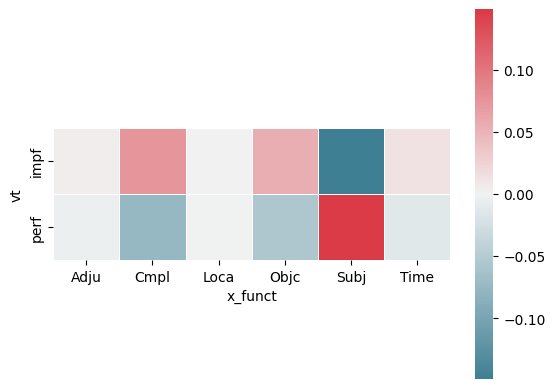

In [319]:
heatmap(vt_funct_dp)